# 9월 20일 소음예측 AI
<br>

### 주요 사항 
- 모델 학습 없이 기존 모델을 로드하고 다른 wav파일을 이에 적용하는 것을 시도했으나, 예측이 잘 되지 않아 다시 모델을 학습시켜봄
- pred.csv -> pred.wav로 바꾸어보아야함

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.models import load_model
import datetime
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment
from scipy.signal import resample
import IPython.display as ipd

In [2]:
uploaded_file_name = 'hhhh.wav'
EXPECTED_SAMPLE_RATE = 44100 #44.1KHz

def convert_audio_for_model(user_file, output_file = 'converted_audio_file.wav'):
    audio = AudioSegment.from_file(user_file, format = "wav")
    audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
    audio.export(output_file, format="wav")
    return output_file

converted_audio_file = convert_audio_for_model(uploaded_file_name)

ipd.Audio(converted_audio_file)

In [3]:
# Loading audio samples from the wav file : 
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# 오디오 정보 출력
duration = len(audio_samples)/sample_rate
print("data :", audio_samples)
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

data : [128 128 128 ... 128 128 128]
Sample rate: 44100 Hz
Total duration: 2.01s
Size of the input: 88445


No handles with labels found to put in legend.


count    88445.000000
mean       127.646741
std         14.170877
min          0.000000
25%        124.000000
50%        128.000000
75%        131.000000
max        229.000000
Name: 0, dtype: float64


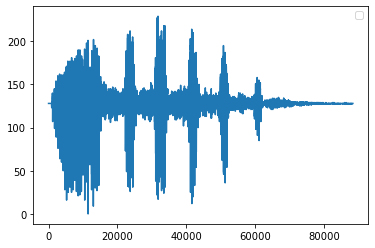

,Unnamed: 0,0
0,0,128
1,1,128
2,2,128
3,3,128
4,4,128
...,...,...
88440,88440,128
88441,88441,128
88442,88442,128
88443,88443,128


In [4]:
# csv파일 불러오기
pd.DataFrame(audio_samples).to_csv("hhhh.csv")
data = pd.read_csv('hhhh.csv')
# train_data = data['0'].values/1000

# data 정보 출력
print(data['0'].describe())
# train data 그래프 출력
plt.plot(data['0'])
#plt.xlim(0,1000)
plt.legend()
plt.show()
data

In [5]:
X = np.arange(len(data)).reshape(-1,1)
y = data['0'].values
y = y.reshape(-1,1)
print("X : \n", X)
print("\ny : \n", y)

X : 
 [[    0]
 [    1]
 [    2]
 ...
 [88442]
 [88443]
 [88444]]

y : 
 [[128]
 [128]
 [128]
 ...
 [128]
 [128]
 [128]]


In [6]:
# 딥러닝 학습을 정상적으로 동작 시키기 위해 데이터 정규화
y_std = y.std()
y_mean = y.mean()
y = (y-y_mean) / y_std
y

array([[0.02492867],
       [0.02492867],
       [0.02492867],
       ...,
       [0.02492867],
       [0.02492867],
       [0.02492867]])

In [7]:
seq_len = 50   #window size : 예측을 위한 데이터 수
prediction = 1  # 다음을 예측할 데이터 수
sequence_length = seq_len + prediction

result = []
for index in range(len(y) - sequence_length):
    result.append(y[index: index + sequence_length])

In [8]:
result = np.array(result)
row = int(round(result.shape[0] * 0.7))
train = result[:row, :]

In [9]:
# 현재를 기준으로 최근 50개 데이터를 시험에 사용하고 그 외의 이전 데이터들은 학습에 사용
test_period = 50

X_train = train[:, :-prediction]
y_train = train[:,-prediction]
X_test = result[row:, :-prediction]
y_test = result[row:, -prediction]

print("shape of X_train : ", X_train.shape)
print("shape of y_train : ", y_train.shape)
print("shape of X_test : ", X_test.shape)
print("shape of y_test : ", y_test.shape)

shape of X_train :  (61876, 50, 1)
shape of y_train :  (61876, 1)
shape of X_test :  (26518, 50, 1)
shape of y_test :  (26518, 1)


In [10]:
# 학습데이터 : 검증데이터 = 7 : 3  (학습이 진행되는 중에도 학습이 정상적으로 이루어지는지 확인하기 위함)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [11]:
# tensorflow에 데이터를 전달하기 전에 입력 형식을 맞추기 위해 2차원 데이터를 3차원 데이터로 변환
X = X.reshape(X.shape[0], X.shape[1], 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("shape of X : ", X.shape)  # data 수 
print("shape of X_train : ", X_train.shape)  # (data 수 - test_period)의 70%
print("shape of X_val : ", X_val.shape)  # (data 수 - test_period)의 30%
print("shape of X_test : ", X_test.shape)  # test_period

shape of X :  (88445, 1, 1)
shape of X_train :  (43313, 50, 1)
shape of X_val :  (18563, 50, 1)
shape of X_test :  (26518, 50, 1)


In [12]:
# 모델 생성
print('Build LSTM RNN model ...')
model = Sequential()

# LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))  # (timestep, feature)
model.add(LSTM(64, return_sequences=False))

# Output(Dense) : 1개 
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Build LSTM RNN model ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [13]:
%%time 
# 트레이닝 값으로 학습
print ("training started..... please wait.")
hist = model.fit(X_train, y_train, epochs = 5, batch_size=10, validation_data=(X_val, y_val))

# 모델 저장
model.save('weight.h5')
print ("training finised!")

training started..... please wait.
Epoch 1/5
4332/4332 [==============================] - 408s 91ms/step - loss: 0.1366 - val_loss: 0.0163
Epoch 2/5
4332/4332 [==============================] - 385s 89ms/step - loss: 0.0164 - val_loss: 0.0138
Epoch 3/5
4332/4332 [==============================] - 401s 93ms/step - loss: 0.0143 - val_loss: 0.0098
Epoch 4/5
4332/4332 [==============================] - 444s 102ms/step - loss: 0.0099 - val_loss: 0.0064
Epoch 5/5
4332/4332 [==============================] - 403s 93ms/step - loss: 0.0070 - val_loss: 0.0047
training finised!
Wall time: 34min 1s


<function matplotlib.pyplot.show(close=None, block=None)>

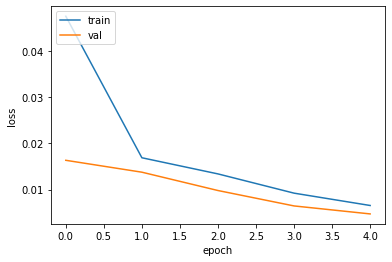

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show

In [15]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
valScore = model.evaluate(X_val, y_val, verbose=0)
testScore = model.evaluate(X_test, y_test, verbose=0)

print('Train Score : ', trainScore)
print('Validation Score : ', valScore)
print('Test Score : ', testScore)

Train Score :  0.004854124505072832
Validation Score :  0.004701088182628155
Test Score :  0.0007125528063625097


In [16]:
pred = model.predict(X_test)  # 모델을 사용하여 예측한다

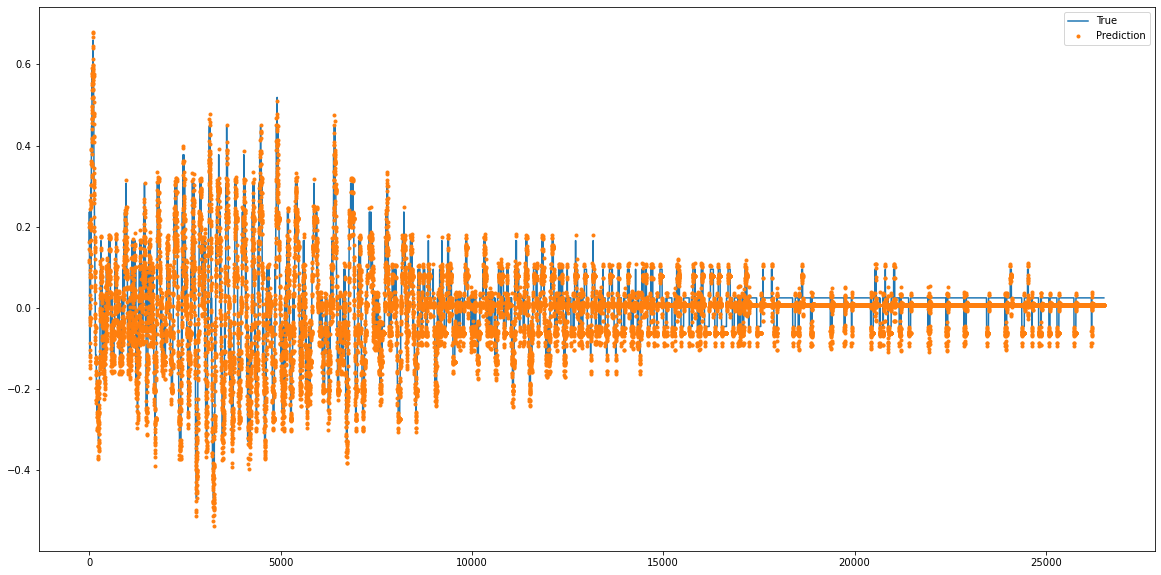

In [17]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, '.', label='Prediction')
ax.legend()
#plt.xlim(1,1000)
plt.show()

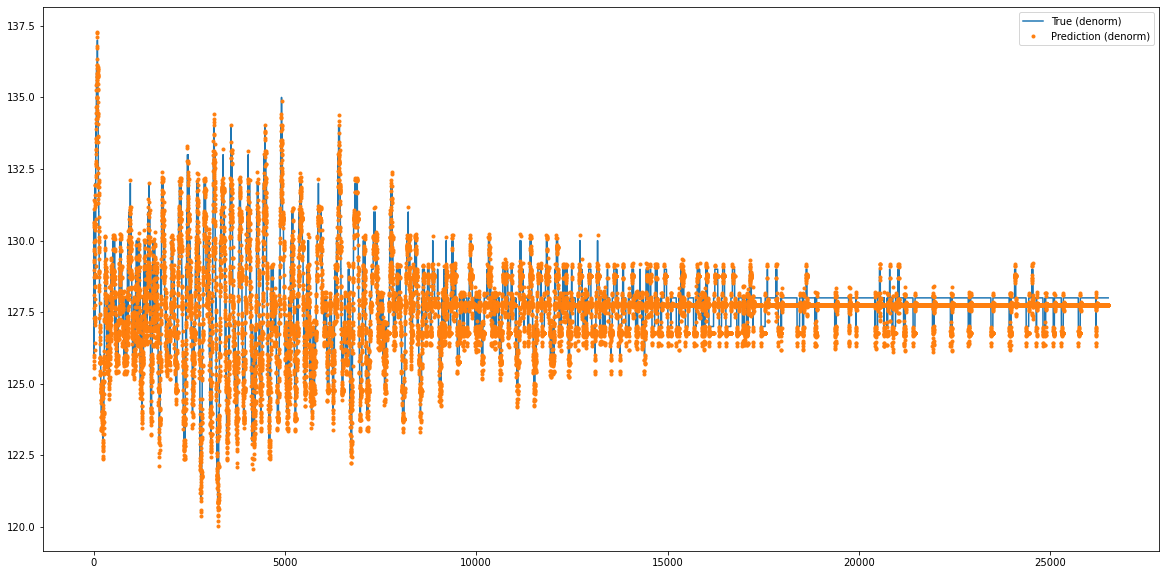

In [18]:
# 정규화된 데이터를 복원하기 위해 사용하는 함수
def denorm(y):
    return y * y_std + y_mean

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(denorm(y_test), label='True (denorm)')
ax.plot(denorm(pred), '.', label='Prediction (denorm)')
ax.legend()
#plt.xlim(0,1000)
plt.show()

In [19]:
# 정규화 됐던 pred를 복원 
pred = denorm(pred)